In [1]:
# ==================================================
# MATCH WINNER PREDICTION PIPELINE
# ==================================================

# Cell 1: Setup and Configuration
# ==================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from pathlib import Path
import warnings
import os
from datetime import datetime

# Sklearn imports
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    f1_score, classification_report, accuracy_score,
    precision_score, recall_score, confusion_matrix, roc_auc_score
)

# SMOTE
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMB_AVAILABLE = True
except ImportError:
    print("Installing imbalanced-learn...")
    import subprocess, sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'imbalanced-learn'])
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMB_AVAILABLE = True

# XGBoost
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False

# Configuration
os.chdir('d:\\ScoreSight')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)

# Paths
MODELS_DIR = Path('models')
VIZ_DIR = Path('visualizations/match_winner')
RAW_MATCH_DATA_PATH = Path('data/match_result/match_result_data.csv')
CURATED_DATA_PATH = Path('data/match_winner/match_winner_prematch_data.csv')
REPORTS_DIR = Path('reports/match_winner')

for dir_path in [MODELS_DIR, VIZ_DIR, CURATED_DATA_PATH.parent, REPORTS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Constants
RANDOM_STATE = 42
TEST_SIZE = 0.2

# Pre-match features (no leakage)
PREMATCH_FEATURES = {
    'home_team_tier': 'Home Team Tier',
    'away_team_tier': 'Away Team Tier',
    'team_tier_diff': 'Tier Difference',
    'home_quality_score': 'Home Quality',
    'away_quality_score': 'Away Quality',
    'rest_advantage': 'Rest Days Advantage',
    'is_midweek': 'Midweek Match'
}

print("="*80)
print("MATCH WINNER PREDICTION PIPELINE")
print("="*80)
print(f"Setup completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"SMOTE Available: {IMB_AVAILABLE}")
print(f"XGBoost Available: {XGB_AVAILABLE}")
print("="*80)

MATCH WINNER PREDICTION PIPELINE
Setup completed at: 2025-11-19 02:39:57
SMOTE Available: True
XGBoost Available: True


In [2]:
# Cell 2: Data Loading and Target Engineering
# ==================================================

def load_and_engineer_target(file_path):
    """
    Load match data and engineer target variable
    
    Parameters:
    -----------
    file_path : Path
        Path to match result data
        
    Returns:
    --------
    df : DataFrame
        Dataframe with engineered target
    target_info : dict
        Target engineering information
    """
    print("\n" + "="*80)
    print("DATA LOADING AND TARGET ENGINEERING")
    print("="*80)
    
    # Load data
    print(f"\n📂 Loading data from: {file_path}")
    df = pd.read_csv(file_path)
    
    # Standardize columns
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')
    
    print(f"✓ Initial shape: {df.shape}")
    
    # Remove duplicates
    duplicates = df.duplicated().sum()
    df.drop_duplicates(inplace=True)
    print(f"✓ Removed {duplicates} duplicate rows")
    
    # Check for required columns
    required_cols = ['fthg', 'ftag']
    missing_cols = [col for col in required_cols if col not in df.columns]
    
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    print(f"✓ Found required score columns: {required_cols}")
    
    # Engineer target from match scores
    print(f"\n🎯 Engineering target variable...")
    
    # Calculate score difference
    df['score_diff'] = df['fthg'].astype(float) - df['ftag'].astype(float)
    
    # Create match result
    conditions = [
        df['score_diff'] > 0,  # Home win
        df['score_diff'] == 0,  # Draw
        df['score_diff'] < 0  # Away win
    ]
    choices = ['Home Win', 'Draw', 'Away Win']
    df['match_result'] = np.select(conditions, choices, default='Unknown')
    
    # Encode target
    label_encoder = LabelEncoder()
    df['target'] = label_encoder.fit_transform(df['match_result'])
    
    # Target distribution
    target_dist = df['match_result'].value_counts()
    print(f"\n✓ Target Distribution:")
    for result, count in target_dist.items():
        pct = count / len(df) * 100
        print(f"   {result}: {count} ({pct:.1f}%)")
    
    target_info = {
        'encoding': dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))),
        'distribution': target_dist.to_dict(),
        'total_matches': len(df)
    }
    
    return df, target_info

# Load and engineer
df_raw, target_info = load_and_engineer_target(RAW_MATCH_DATA_PATH)


DATA LOADING AND TARGET ENGINEERING

📂 Loading data from: data\match_result\match_result_data.csv
✓ Initial shape: (6840, 81)
✓ Removed 0 duplicate rows
✓ Found required score columns: ['fthg', 'ftag']

🎯 Engineering target variable...

✓ Target Distribution:
   Home Win: 3176 (46.4%)
   Away Win: 1913 (28.0%)
   Draw: 1751 (25.6%)


In [3]:
# Cell 3: Feature Engineering and Validation
# ==================================================

def engineer_and_validate_features(df, feature_dict):
    """
    Engineer pre-match features and validate
    
    Parameters:
    -----------
    df : DataFrame
        Raw dataframe
    feature_dict : dict
        Dictionary of features to use
        
    Returns:
    --------
    df_model : DataFrame
        Modeling dataframe
    feature_info : dict
        Feature information
    """
    print("\n" + "="*80)
    print("FEATURE ENGINEERING AND VALIDATION")
    print("="*80)
    
    feature_cols = list(feature_dict.keys())
    
    # Check feature availability
    print(f"\n🔍 Checking feature availability...")
    missing_features = [f for f in feature_cols if f not in df.columns]
    
    if missing_features:
        print(f"⚠️  Missing features: {missing_features}")
        print(f"Available columns: {sorted(df.columns.tolist())}")
        raise ValueError(f"Cannot proceed without required features")
    
    print(f"✓ All {len(feature_cols)} features available")
    
    # Select features and target
    df_model = df[feature_cols + ['target', 'match_result']].copy()
    
    # Check for missing values
    missing_counts = df_model[feature_cols].isnull().sum()
    missing_features = missing_counts[missing_counts > 0]
    
    if len(missing_features) > 0:
        print(f"\n⚠️  Features with missing values:")
        print(missing_features)
        
        # Remove rows with missing features
        before = len(df_model)
        df_model = df_model.dropna(subset=feature_cols)
        after = len(df_model)
        print(f"✓ Removed {before - after} rows with missing values")
    else:
        print(f"\n✓ No missing values in features")
    
    # Feature statistics
    print(f"\n📊 Feature Statistics:")
    feature_stats = df_model[feature_cols].describe().T
    feature_stats['friendly_name'] = [feature_dict[col] for col in feature_stats.index]
    print(feature_stats[['friendly_name', 'mean', 'std', 'min', 'max']])
    
    # Check correlations
    print(f"\n🔗 Feature Correlations with Target:")
    correlations = df_model[feature_cols + ['target']].corr()['target'].drop('target').sort_values(ascending=False)
    for feat, corr in correlations.items():
        print(f"   {feature_dict[feat]}: {corr:.3f}")
    
    feature_info = {
        'features': feature_cols,
        'friendly_names': feature_dict,
        'statistics': feature_stats.to_dict(),
        'correlations': correlations.to_dict(),
        'final_samples': len(df_model)
    }
    
    return df_model, feature_info

# Engineer features
df_model, feature_info = engineer_and_validate_features(df_raw, PREMATCH_FEATURES)


FEATURE ENGINEERING AND VALIDATION

🔍 Checking feature availability...
✓ All 7 features available

✓ No missing values in features

📊 Feature Statistics:
                          friendly_name      mean         std     min  \
home_team_tier           Home Team Tier  1.716667    0.783745     1.0   
away_team_tier           Away Team Tier  1.716667    0.783745     1.0   
team_tier_diff          Tier Difference  0.000000    1.124505    -2.0   
home_quality_score         Home Quality  0.503634    0.258309     0.0   
away_quality_score         Away Quality  0.503634    0.258309     0.0   
rest_advantage      Rest Days Advantage  0.121199  125.043632 -3593.0   
is_midweek                Midweek Match  0.322076    0.467306     0.0   

                            max  
home_team_tier         3.000000  
away_team_tier         3.000000  
team_tier_diff         2.000000  
home_quality_score     0.996823  
away_quality_score     0.996823  
rest_advantage      3344.000000  
is_midweek            


EXPLORATORY DATA ANALYSIS

📊 Creating target distribution plot...


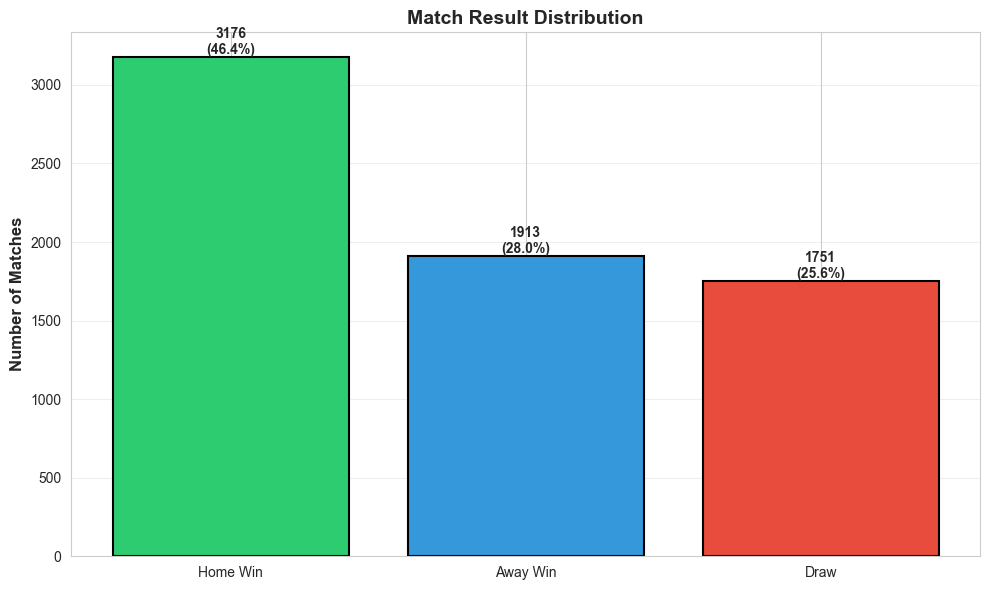

✓ Saved to: visualizations\match_winner\target_distribution.png

📊 Creating feature distribution plots...


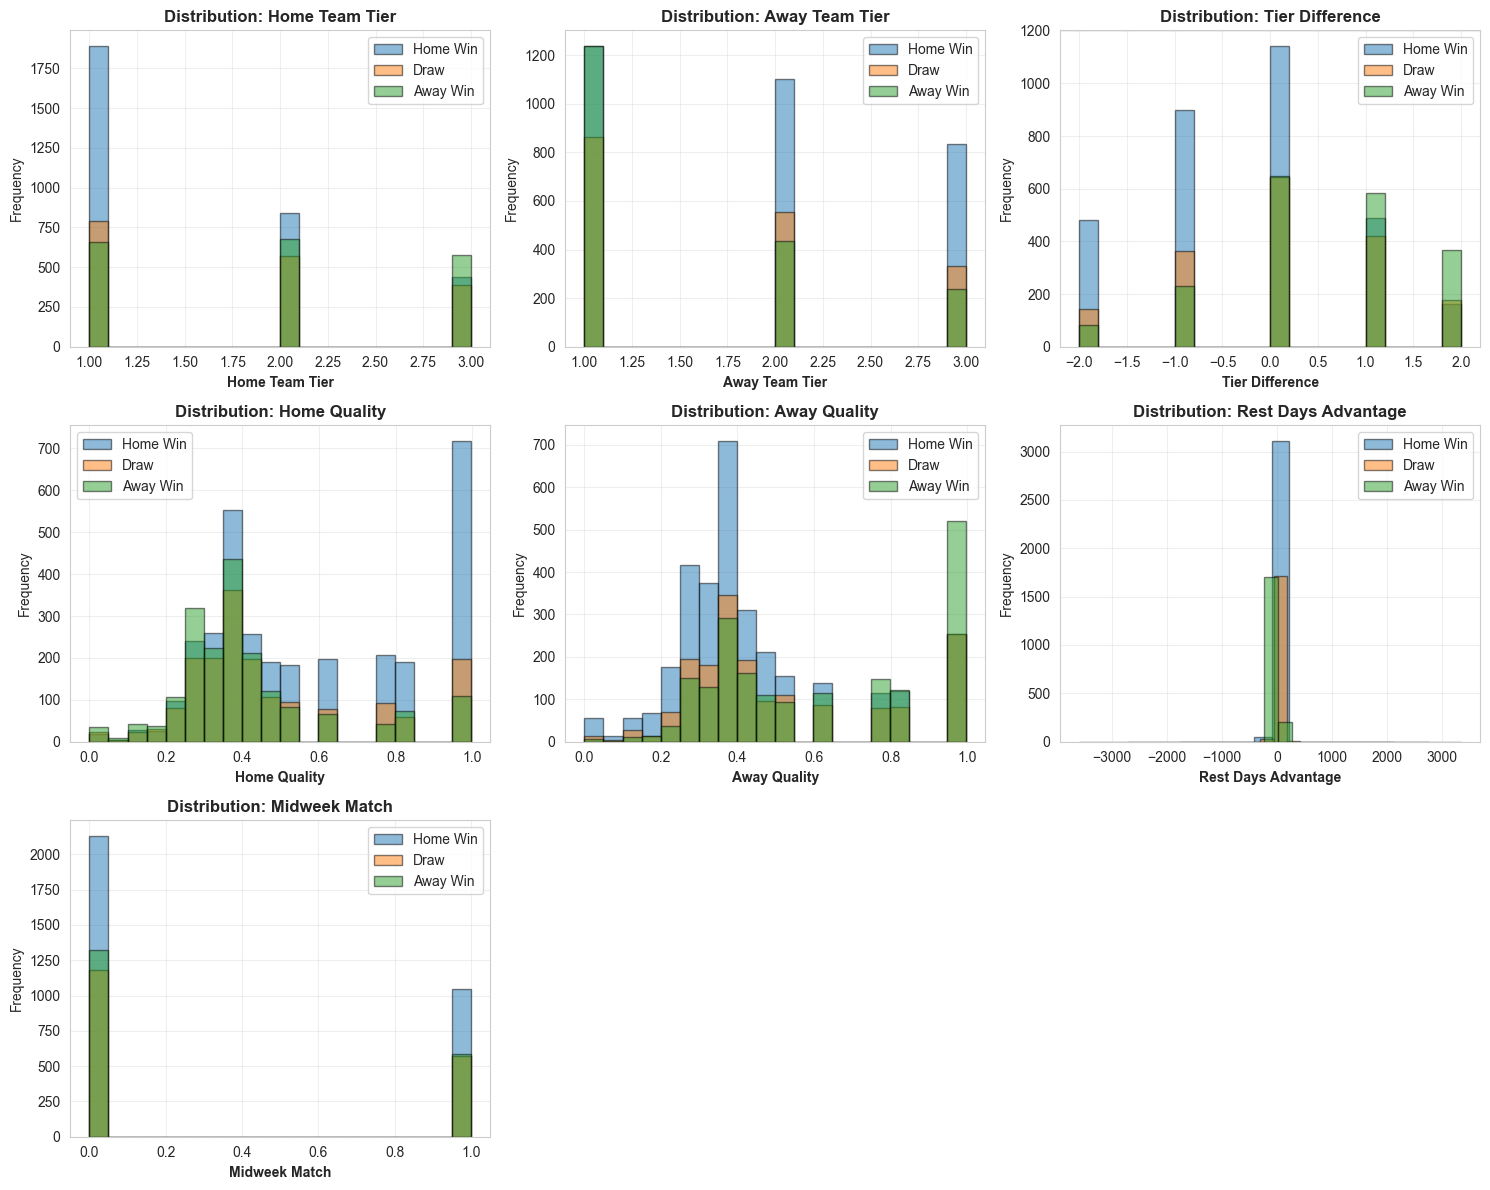

✓ Saved to: visualizations\match_winner\feature_distributions_by_outcome.png

🔥 Creating correlation heatmap...


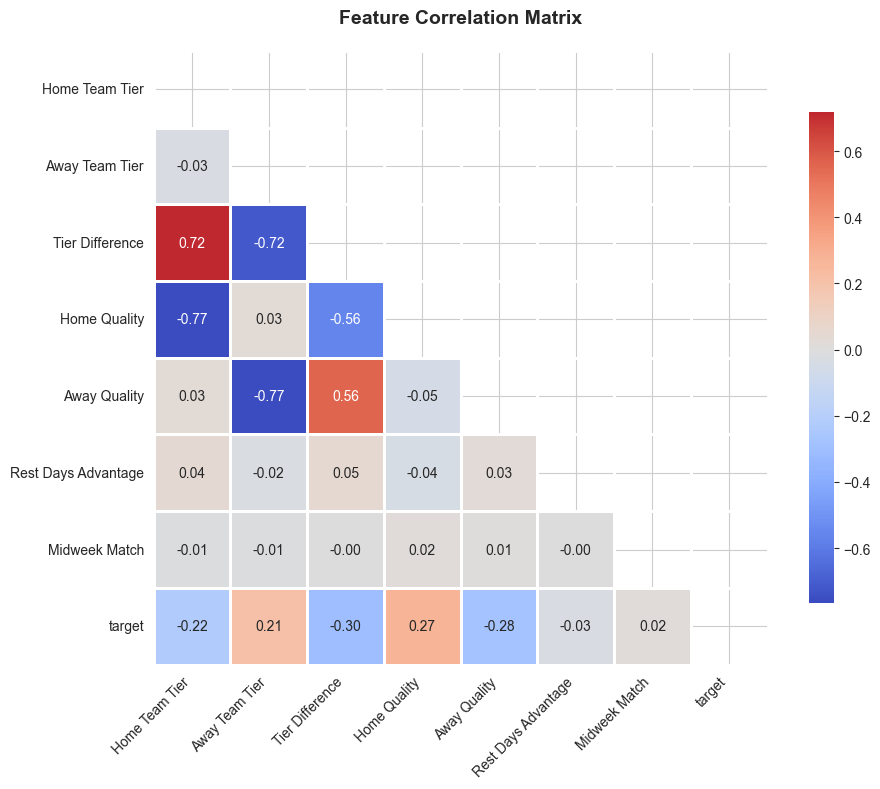

✓ Saved to: visualizations\match_winner\correlation_heatmap.png

📦 Creating box plots...


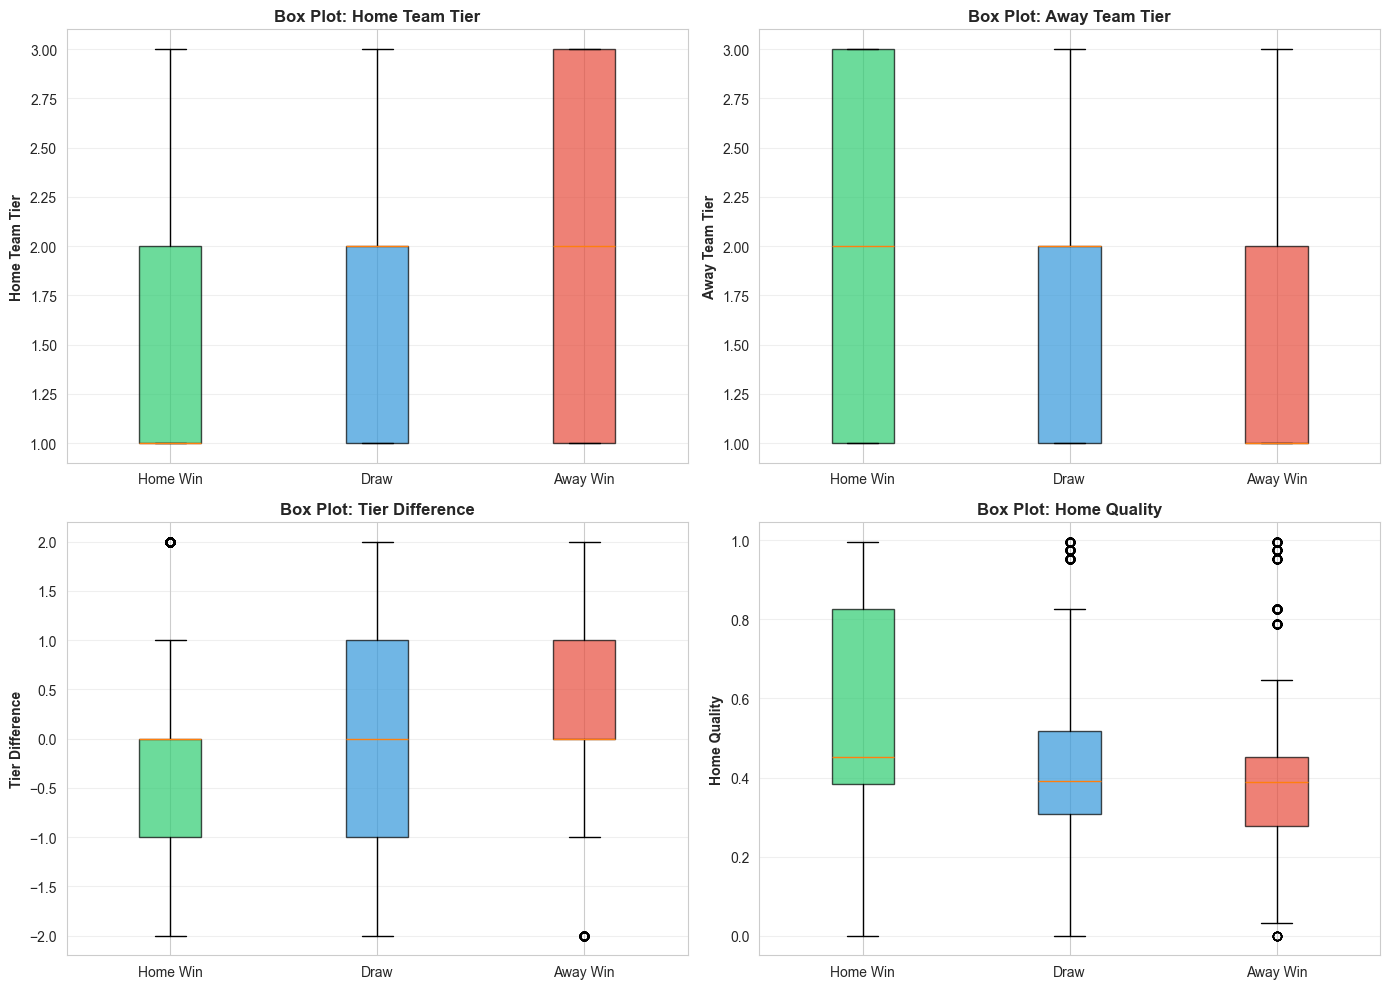

✓ Saved to: visualizations\match_winner\feature_boxplots.png

💾 Processed data saved to: data\match_winner\match_winner_prematch_data.csv


In [4]:
# Cell 4: Exploratory Data Analysis
# ==================================================

def create_match_eda_visualizations(df, feature_info, target_info, save_dir):
    """
    Create EDA visualizations for match prediction
    
    Parameters:
    -----------
    df : DataFrame
        Modeling dataframe
    feature_info : dict
        Feature information
    target_info : dict
        Target information
    save_dir : Path
        Save directory
    """
    print("\n" + "="*80)
    print("EXPLORATORY DATA ANALYSIS")
    print("="*80)
    
    features = feature_info['features']
    friendly_names = feature_info['friendly_names']
    
    # 1. Target Distribution
    print("\n📊 Creating target distribution plot...")
    fig, ax = plt.subplots(figsize=(10, 6))
    
    result_counts = df['match_result'].value_counts()
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    bars = ax.bar(result_counts.index, result_counts.values, color=colors, edgecolor='black', linewidth=1.5)
    
    ax.set_ylabel('Number of Matches', fontweight='bold', fontsize=12)
    ax.set_title('Match Result Distribution', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add percentages
    total = result_counts.sum()
    for bar, count in zip(bars, result_counts.values):
        height = bar.get_height()
        pct = count / total * 100
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}\n({pct:.1f}%)',
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    target_path = save_dir / 'target_distribution.png'
    plt.savefig(target_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved to: {target_path}")
    
    # 2. Feature distributions by outcome
    print("\n📊 Creating feature distribution plots...")
    n_features = len(features)
    n_cols = 3
    n_rows = int(np.ceil(n_features / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten() if n_features > 1 else [axes]
    
    for idx, feature in enumerate(features):
        ax = axes[idx]
        
        for result in ['Home Win', 'Draw', 'Away Win']:
            data = df[df['match_result'] == result][feature]
            ax.hist(data, bins=20, alpha=0.5, label=result, edgecolor='black')
        
        ax.set_xlabel(friendly_names[feature], fontweight='bold')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution: {friendly_names[feature]}', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    for idx in range(n_features, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    dist_path = save_dir / 'feature_distributions_by_outcome.png'
    plt.savefig(dist_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved to: {dist_path}")
    
    # 3. Feature correlation heatmap
    print("\n🔥 Creating correlation heatmap...")
    fig, ax = plt.subplots(figsize=(10, 8))
    
    corr_data = df[features + ['target']].corr()
    mask = np.triu(np.ones_like(corr_data, dtype=bool))
    
    sns.heatmap(corr_data, mask=mask, annot=True, fmt='.2f',
                cmap='coolwarm', center=0, square=True,
                linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
    
    # Use friendly names for labels
    labels = [friendly_names.get(col, col) for col in corr_data.columns]
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels, rotation=0)
    ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    corr_path = save_dir / 'correlation_heatmap.png'
    plt.savefig(corr_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved to: {corr_path}")
    
    # 4. Box plots for key features
    print("\n📦 Creating box plots...")
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    key_features = features[:4]  # Plot first 4 features
    
    for idx, feature in enumerate(key_features):
        ax = axes[idx]
        
        data_to_plot = [df[df['match_result'] == result][feature].values 
                        for result in ['Home Win', 'Draw', 'Away Win']]
        
        bp = ax.boxplot(data_to_plot, labels=['Home Win', 'Draw', 'Away Win'],
                        patch_artist=True)
        
        # Color boxes
        colors = ['#2ecc71', '#3498db', '#e74c3c']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax.set_ylabel(friendly_names[feature], fontweight='bold')
        ax.set_title(f'Box Plot: {friendly_names[feature]}', fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    box_path = save_dir / 'feature_boxplots.png'
    plt.savefig(box_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved to: {box_path}")

# Create EDA visualizations
create_match_eda_visualizations(df_model, feature_info, target_info, VIZ_DIR)

# Save processed data
df_model.to_csv(CURATED_DATA_PATH, index=False)
print(f"\n💾 Processed data saved to: {CURATED_DATA_PATH}")

In [5]:
# Cell 5: Model Training and Evaluation
# ==================================================

def train_match_prediction_models(df, feature_info, random_state=42):
    """
    Train multiple models for match prediction
    
    Parameters:
    -----------
    df : DataFrame
        Modeling dataframe
    feature_info : dict
        Feature information
    random_state : int
        Random seed
        
    Returns:
    --------
    results : dict
        Training results
    """
    print("\n" + "="*80)
    print("MODEL TRAINING AND EVALUATION")
    print("="*80)
    
    features = feature_info['features']
    
    X = df[features]
    y = df['target']
    
    print(f"\n📊 Dataset Info:")
    print(f"   Features: {len(features)}")
    print(f"   Samples: {len(X)}")
    print(f"   Classes: {len(np.unique(y))}")
    
    # Class distribution
    unique, counts = np.unique(y, return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"   Class {cls}: {count} samples")
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=random_state, stratify=y
    )
    
    print(f"\n✂️  Train-Test Split:")
    print(f"   Training: {len(X_train)} samples")
    print(f"   Testing: {len(X_test)} samples")
    
    # Define models
    models = {
        'LogisticRegression': LogisticRegression(
            max_iter=1000,
            multi_class='multinomial',
            random_state=random_state,
            n_jobs=-1
        ),
        'RandomForest': RandomForestClassifier(
            random_state=random_state,
            n_jobs=-1
        ),
        'GradientBoosting': GradientBoostingClassifier(
            random_state=random_state
        )
    }
    
    if XGB_AVAILABLE:
        models['XGBoost'] = xgb.XGBClassifier(
            random_state=random_state,
            use_label_encoder=False,
            eval_metric='mlogloss',
            n_jobs=-1
        )
    
    # Hyperparameter grids
    param_grids = {
        'LogisticRegression': {
            'model__C': [0.01, 0.1, 1.0, 10.0],
            'model__penalty': ['l2']
        },
        'RandomForest': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [10, 20, None],
            'model__min_samples_split': [2, 5]
        },
        'GradientBoosting': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__max_depth': [3, 5]
        },
        'XGBoost': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__max_depth': [3, 5]
        }
    }
    
    # Train models
    training_results = []
    trained_models = {}
    
    for model_name, model in models.items():
        print(f"\n{'='*60}")
        print(f"Training: {model_name}")
        print(f"{'='*60}")
        
        # Create pipeline
        pipeline = ImbPipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=random_state)),
            ('model', model)
        ])
        
        # Hyperparameter search
        search = RandomizedSearchCV(
            pipeline,
            param_distributions=param_grids[model_name],
            n_iter=15,
            cv=StratifiedKFold(5, shuffle=True, random_state=random_state),
            scoring='f1_macro',
            n_jobs=-1,
            random_state=random_state,
            verbose=0
        )
        
        # Fit
        search.fit(X_train, y_train)
        
        # Predictions
        y_pred = search.predict(X_test)
        
        # Metrics
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_weighted = f1_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
        
        results_dict = {
            'Model': model_name,
            'Best_CV_F1': search.best_score_,
            'Test_F1_Macro': f1_macro,
            'Test_F1_Weighted': f1_weighted,
            'Test_Accuracy': accuracy,
            'Test_Precision': precision,
            'Test_Recall': recall
        }
        
        training_results.append(results_dict)
        trained_models[model_name] = {
            'pipeline': search.best_estimator_,
            'search': search,
            'predictions': y_pred,
            'metrics': results_dict
        }
        
        print(f"✓ Best CV F1: {search.best_score_:.4f}")
        print(f"✓ Test F1 (Macro): {f1_macro:.4f}")
        print(f"✓ Test Accuracy: {accuracy:.4f}")
    
    # Summary
    summary_df = pd.DataFrame(training_results).sort_values(
        'Test_F1_Macro', ascending=False
    )
    
    print(f"\n{'='*80}")
    print("MODEL COMPARISON SUMMARY")
    print(f"{'='*80}")
    display(summary_df.style.format({
        'Best_CV_F1': '{:.4f}',
        'Test_F1_Macro': '{:.4f}',
        'Test_F1_Weighted': '{:.4f}',
        'Test_Accuracy': '{:.4f}',
        'Test_Precision': '{:.4f}',
        'Test_Recall': '{:.4f}'
    }).background_gradient(subset=['Test_F1_Macro'], cmap='YlGn'))
    
    best_model_name = summary_df.iloc[0]['Model']
    best_model_data = trained_models[best_model_name]
    
    print(f"\n🏆 Best Model: {best_model_name}")
    
    return {
        'summary': summary_df,
        'trained_models': trained_models,
        'best_model_name': best_model_name,
        'best_model': best_model_data,
        'X_test': X_test,
        'y_test': y_test
    }

# Train models
training_results = train_match_prediction_models(df_model, feature_info, RANDOM_STATE)


MODEL TRAINING AND EVALUATION

📊 Dataset Info:
   Features: 7
   Samples: 6840
   Classes: 3
   Class 0: 1913 samples
   Class 1: 1751 samples
   Class 2: 3176 samples

✂️  Train-Test Split:
   Training: 5472 samples
   Testing: 1368 samples

Training: LogisticRegression
✓ Best CV F1: 0.4618
✓ Test F1 (Macro): 0.4623
✓ Test Accuracy: 0.4803

Training: RandomForest
✓ Best CV F1: 0.4618
✓ Test F1 (Macro): 0.4623
✓ Test Accuracy: 0.4803

Training: RandomForest
✓ Best CV F1: 0.4434
✓ Test F1 (Macro): 0.4382
✓ Test Accuracy: 0.4693

Training: GradientBoosting
✓ Best CV F1: 0.4434
✓ Test F1 (Macro): 0.4382
✓ Test Accuracy: 0.4693

Training: GradientBoosting
✓ Best CV F1: 0.4565
✓ Test F1 (Macro): 0.4528
✓ Test Accuracy: 0.4766

Training: XGBoost
✓ Best CV F1: 0.4565
✓ Test F1 (Macro): 0.4528
✓ Test Accuracy: 0.4766

Training: XGBoost
✓ Best CV F1: 0.4587
✓ Test F1 (Macro): 0.4488
✓ Test Accuracy: 0.4744

MODEL COMPARISON SUMMARY
✓ Best CV F1: 0.4587
✓ Test F1 (Macro): 0.4488
✓ Test Accuracy

,Model,Best_CV_F1,Test_F1_Macro,Test_F1_Weighted,Test_Accuracy,Test_Precision,Test_Recall
0,LogisticRegression,0.4618,0.4623,0.4851,0.4803,0.4650,0.4698
2,GradientBoosting,0.4565,0.4528,0.4777,0.4766,0.4525,0.4602
3,XGBoost,0.4587,0.4488,0.4757,0.4744,0.4490,0.4562
1,RandomForest,0.4434,0.4382,0.4682,0.4693,0.4365,0.4444



🏆 Best Model: LogisticRegression



BEST MODEL ANALYSIS

🏆 Model: LogisticRegression

📊 Classification Report:
              precision    recall  f1-score   support

    Home Win     0.4607    0.5822    0.5144       383
        Draw     0.2940    0.3200    0.3064       350
    Away Win     0.6402    0.5071    0.5659       635

    accuracy                         0.4803      1368
   macro avg     0.4650    0.4698    0.4623      1368
weighted avg     0.5014    0.4803    0.4851      1368


📈 Confusion Matrix:


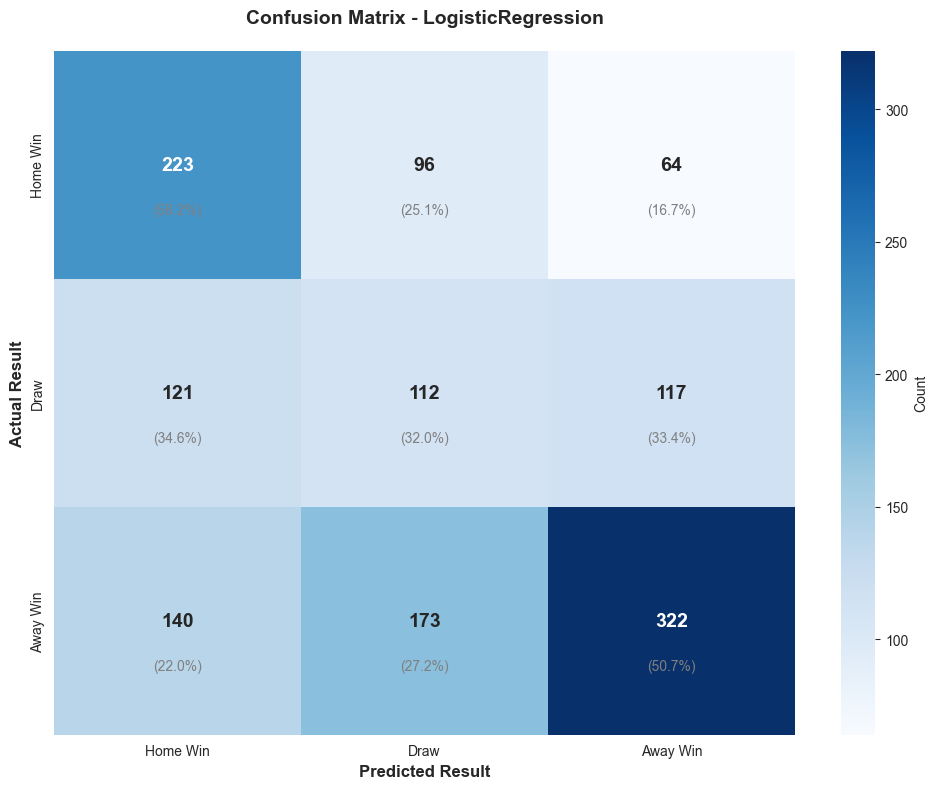

✓ Saved to: visualizations\match_winner\confusion_matrix_LogisticRegression.png

📊 Per-Class Performance:


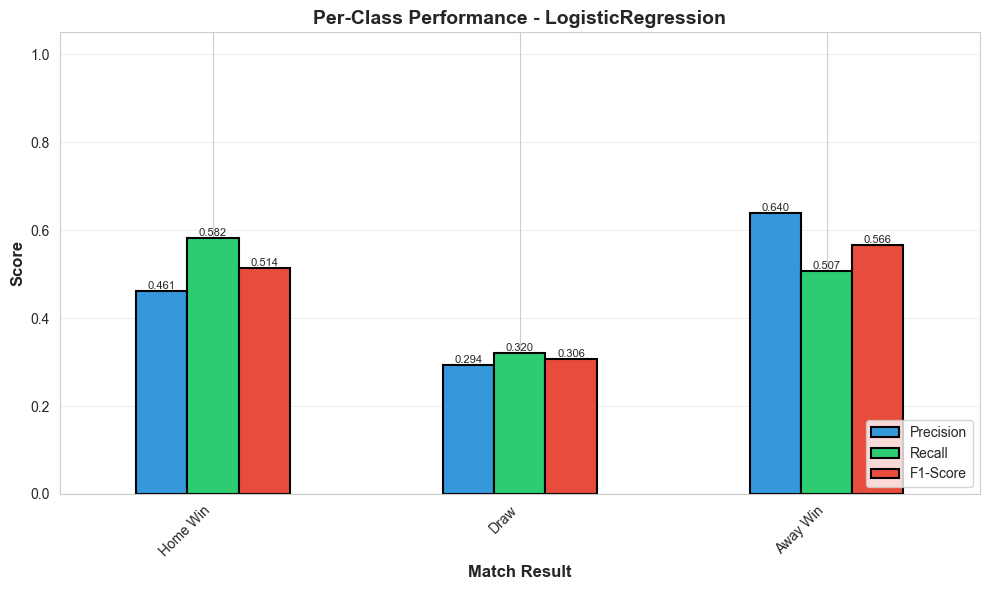

✓ Saved to: visualizations\match_winner\per_class_performance_LogisticRegression.png

⭐ Feature Coefficients:


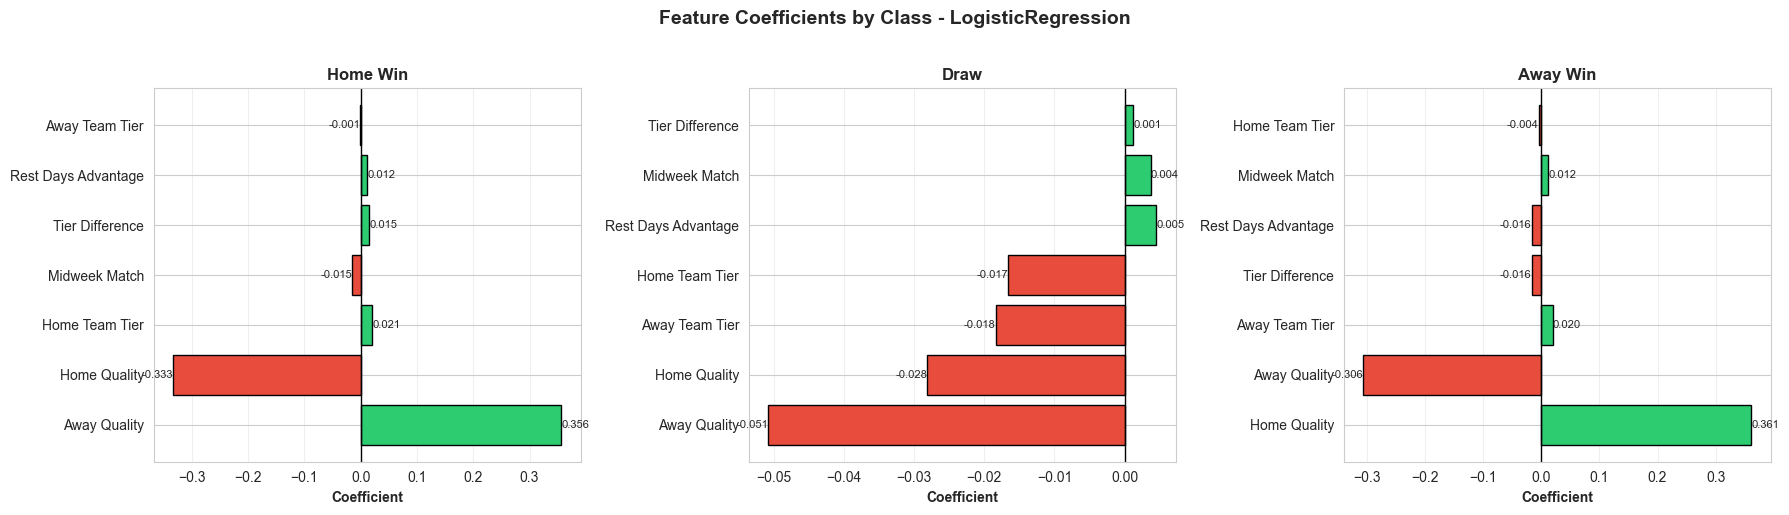

✓ Saved to: visualizations\match_winner\feature_coefficients_LogisticRegression.png

📊 Creating Model Comparison Dashboard:


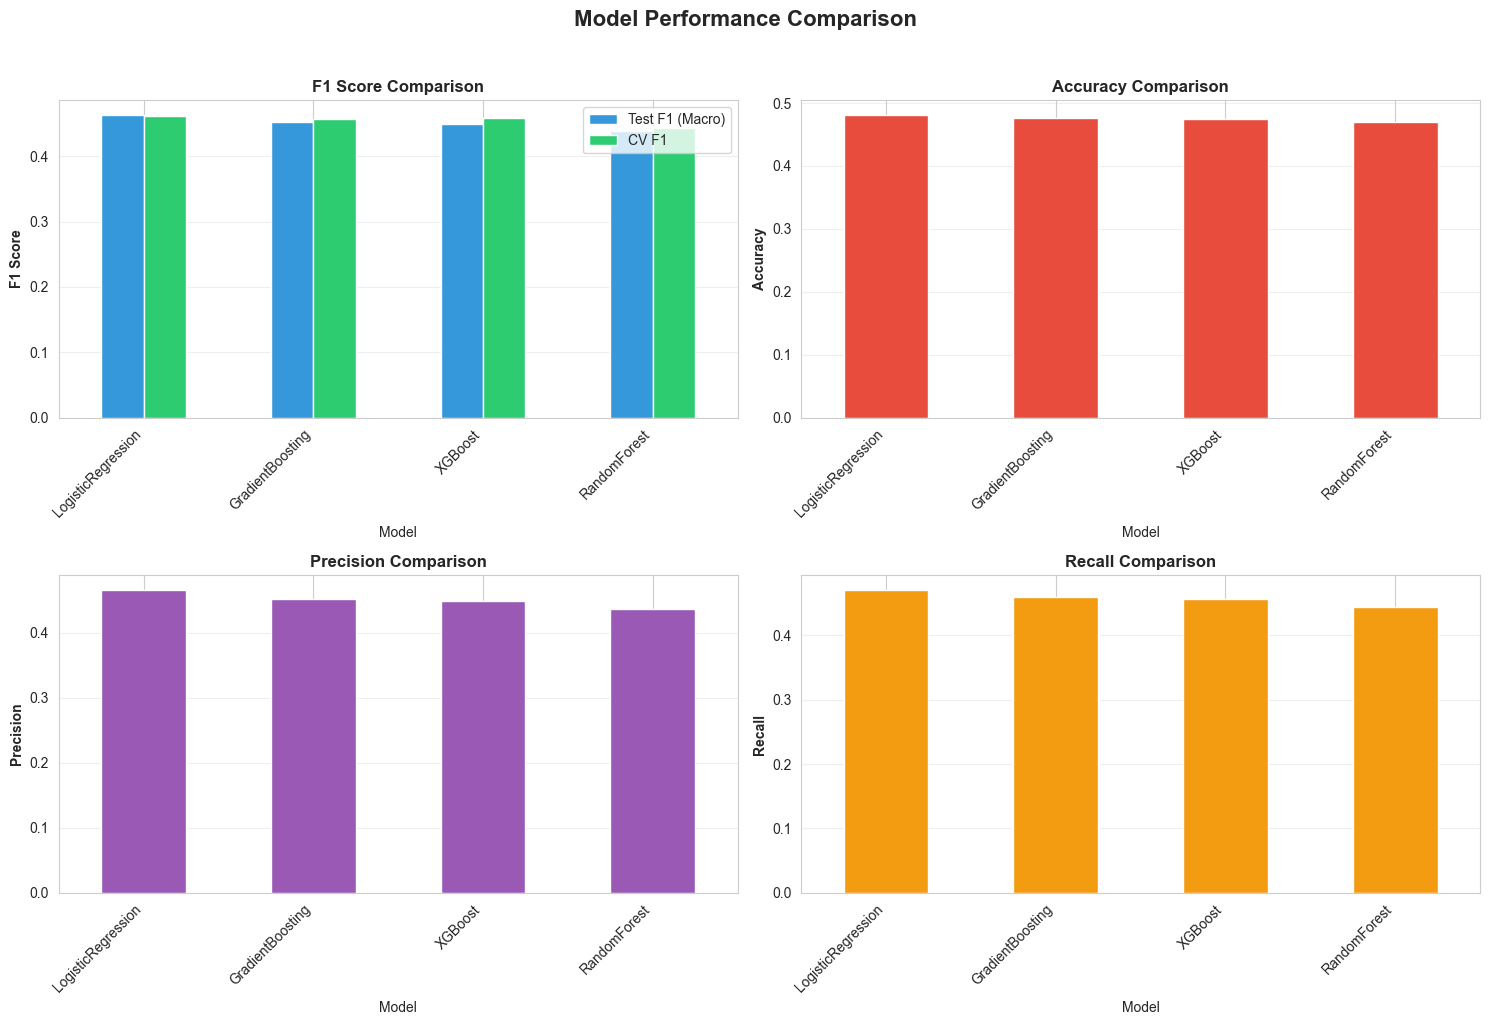

✓ Saved to: visualizations\match_winner\model_comparison_dashboard.png


In [6]:
# Cell 6: Detailed Model Analysis
# ==================================================

def analyze_match_prediction_model(results, feature_info, target_info, save_dir):
    """
    Analyze best match prediction model
    
    Parameters:
    -----------
    results : dict
        Training results
    feature_info : dict
        Feature information
    target_info : dict
        Target information
    save_dir : Path
        Save directory
    """
    print("\n" + "="*80)
    print("BEST MODEL ANALYSIS")
    print("="*80)
    
    best_model_name = results['best_model_name']
    best_model_data = results['best_model']
    y_test = results['y_test']
    y_pred = best_model_data['predictions']
    
    print(f"\n🏆 Model: {best_model_name}")
    
    # Classification report
    class_names = ['Home Win', 'Draw', 'Away Win']
    print(f"\n📊 Classification Report:")
    print("="*60)
    report = classification_report(y_test, y_pred, target_names=class_names, digits=4)
    print(report)
    
    # Confusion Matrix
    print(f"\n📈 Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Count'}, ax=ax,
                annot_kws={'size': 14, 'weight': 'bold'})
    
    ax.set_xlabel('Predicted Result', fontweight='bold', fontsize=12)
    ax.set_ylabel('Actual Result', fontweight='bold', fontsize=12)
    ax.set_title(f'Confusion Matrix - {best_model_name}', 
                 fontsize=14, fontweight='bold', pad=20)
    
    # Add percentage annotations
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j + 0.5, i + 0.7, f'({cm_percent[i, j]:.1f}%)',
                   ha="center", va="center", color="gray", fontsize=10)
    
    plt.tight_layout()
    cm_path = save_dir / f'confusion_matrix_{best_model_name}.png'
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved to: {cm_path}")
    
    # Per-class metrics visualization
    print(f"\n📊 Per-Class Performance:")
    
    # Extract per-class metrics
    report_dict = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    
    metrics_df = pd.DataFrame({
        'Precision': [report_dict[cls]['precision'] for cls in class_names],
        'Recall': [report_dict[cls]['recall'] for cls in class_names],
        'F1-Score': [report_dict[cls]['f1-score'] for cls in class_names]
    }, index=class_names)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    metrics_df.plot(kind='bar', ax=ax, color=['#3498db', '#2ecc71', '#e74c3c'],
                    edgecolor='black', linewidth=1.5)
    
    ax.set_ylabel('Score', fontweight='bold', fontsize=12)
    ax.set_xlabel('Match Result', fontweight='bold', fontsize=12)
    ax.set_title(f'Per-Class Performance - {best_model_name}', 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_ylim([0, 1.05])
    
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', fontsize=8)
    
    plt.tight_layout()
    class_perf_path = save_dir / f'per_class_performance_{best_model_name}.png'
    plt.savefig(class_perf_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved to: {class_perf_path}")
    
    # Feature importance (if available)
    pipeline = best_model_data['pipeline']
    model = pipeline.named_steps['model']
    
    if hasattr(model, 'feature_importances_'):
        print(f"\n⭐ Feature Importance:")
        
        importances = model.feature_importances_
        features = feature_info['features']
        friendly_names = feature_info['friendly_names']
        
        # Sort by importance
        indices = np.argsort(importances)[::-1]
        sorted_features = [features[i] for i in indices]
        sorted_importances = importances[indices]
        sorted_names = [friendly_names[f] for f in sorted_features]
        
        # Print
        for i, (feat, name, imp) in enumerate(zip(sorted_features, sorted_names, sorted_importances), 1):
            print(f"   {i}. {name}: {imp:.4f}")
        
        # Plot
        fig, ax = plt.subplots(figsize=(10, 6))
        colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(sorted_names)))
        bars = ax.barh(sorted_names, sorted_importances, color=colors, edgecolor='black')
        
        ax.set_xlabel('Importance Score', fontweight='bold', fontsize=12)
        ax.set_ylabel('Features', fontweight='bold', fontsize=12)
        ax.set_title(f'Feature Importance - {best_model_name}', 
                     fontsize=14, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for bar in bars:
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2, 
                    f'{width:.3f}', ha='left', va='center', 
                    fontweight='bold', fontsize=9)
        
        plt.tight_layout()
        fi_path = save_dir / f'feature_importance_{best_model_name}.png'
        plt.savefig(fi_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✓ Saved to: {fi_path}")
    
    elif hasattr(model, 'coef_'):
        print(f"\n⭐ Feature Coefficients:")
        
        # For logistic regression, show coefficients for each class
        coefs = model.coef_
        features = feature_info['features']
        friendly_names = feature_info['friendly_names']
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        for idx, (ax, class_name) in enumerate(zip(axes, class_names)):
            coef = coefs[idx]
            
            # Sort by absolute value
            indices = np.argsort(np.abs(coef))[::-1]
            sorted_features = [features[i] for i in indices]
            sorted_coefs = coef[indices]
            sorted_names = [friendly_names[f] for f in sorted_features]
            
            colors = ['#e74c3c' if c < 0 else '#2ecc71' for c in sorted_coefs]
            bars = ax.barh(sorted_names, sorted_coefs, color=colors, edgecolor='black')
            
            ax.set_xlabel('Coefficient', fontweight='bold')
            ax.set_title(f'{class_name}', fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            ax.axvline(x=0, color='black', linewidth=1)
            
            # Add value labels
            for bar in bars:
                width = bar.get_width()
                ax.text(width, bar.get_y() + bar.get_height()/2, 
                        f'{width:.3f}', ha='left' if width > 0 else 'right', 
                        va='center', fontsize=8)
        
        plt.suptitle(f'Feature Coefficients by Class - {best_model_name}', 
                     fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        coef_path = save_dir / f'feature_coefficients_{best_model_name}.png'
        plt.savefig(coef_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✓ Saved to: {coef_path}")
    
    # Model comparison dashboard
    print(f"\n📊 Creating Model Comparison Dashboard:")
    summary = results['summary']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # F1 Scores
    ax = axes[0, 0]
    summary.plot(x='Model', y=['Test_F1_Macro', 'Best_CV_F1'], 
                 kind='bar', ax=ax, color=['#3498db', '#2ecc71'])
    ax.set_ylabel('F1 Score', fontweight='bold')
    ax.set_title('F1 Score Comparison', fontweight='bold')
    ax.legend(['Test F1 (Macro)', 'CV F1'])
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(summary['Model'], rotation=45, ha='right')
    
    # Accuracy
    ax = axes[0, 1]
    summary.plot(x='Model', y='Test_Accuracy', kind='bar', ax=ax, 
                 color='#e74c3c', legend=False)
    ax.set_ylabel('Accuracy', fontweight='bold')
    ax.set_title('Accuracy Comparison', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(summary['Model'], rotation=45, ha='right')
    
    # Precision
    ax = axes[1, 0]
    summary.plot(x='Model', y='Test_Precision', kind='bar', ax=ax, 
                 color='#9b59b6', legend=False)
    ax.set_ylabel('Precision', fontweight='bold')
    ax.set_title('Precision Comparison', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(summary['Model'], rotation=45, ha='right')
    
    # Recall
    ax = axes[1, 1]
    summary.plot(x='Model', y='Test_Recall', kind='bar', ax=ax, 
                 color='#f39c12', legend=False)
    ax.set_ylabel('Recall', fontweight='bold')
    ax.set_title('Recall Comparison', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(summary['Model'], rotation=45, ha='right')
    
    plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    comp_path = save_dir / 'model_comparison_dashboard.png'
    plt.savefig(comp_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved to: {comp_path}")

# Analyze best model
analyze_match_prediction_model(training_results, feature_info, target_info, VIZ_DIR)

In [7]:
# Cell 7: Save Models and Generate Report
# ==================================================

def save_match_models_and_report(results, feature_info, target_info):
    """
    Save models and generate final report
    
    Parameters:
    -----------
    results : dict
        Training results
    feature_info : dict
        Feature information
    target_info : dict
        Target information
    """
    print("\n" + "="*80)
    print("SAVING MODELS AND GENERATING REPORT")
    print("="*80)
    
    best_model_name = results['best_model_name']
    best_model_data = results['best_model']
    
    # Save best model
    model_path = MODELS_DIR / f'match_winner_best_model_{best_model_name}.joblib'
    joblib.dump(best_model_data['pipeline'], model_path)
    print(f"\n✓ Best model saved to: {model_path}")
    
    # Save all models
    for model_name, model_data in results['trained_models'].items():
        model_path = MODELS_DIR / f'match_winner_{model_name}.joblib'
        joblib.dump(model_data['pipeline'], model_path)
        print(f"✓ {model_name} model saved to: {model_path}")
    
    # Generate report
    final_report = {
        'pipeline_info': {
            'name': 'Match Winner Prediction',
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'random_state': RANDOM_STATE,
            'test_size': TEST_SIZE
        },
        'target_engineering': target_info,
        'feature_engineering': feature_info,
        'model_performance': {
            'best_model': best_model_name,
            'all_models': results['summary'].to_dict('records')
        },
        'best_model_metrics': best_model_data['metrics']
    }
    
    # Save JSON report
    report_path = REPORTS_DIR / 'final_pipeline_report.json'
    with open(report_path, 'w') as f:
        json.dump(final_report, f, indent=2, default=str)
    
    print(f"\n✓ Final report saved to: {report_path}")
    
    # Create text summary
    summary_text = f"""
{'='*80}
MATCH WINNER PREDICTION - FINAL REPORT
{'='*80}

Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

TARGET DISTRIBUTION
{'='*80}
{chr(10).join(f"  - {k}: {v} matches" for k, v in target_info['distribution'].items())}
Total Matches: {target_info['total_matches']}

FEATURES USED
{'='*80}
{chr(10).join(f"  - {feature_info['friendly_names'][f]}" for f in feature_info['features'])}

These are PRE-MATCH features only - no post-match data used to prevent leakage.

MODEL PERFORMANCE
{'='*80}
Best Model: {best_model_name}

Metrics:
  - Test F1 (Macro): {best_model_data['metrics']['Test_F1_Macro']:.4f}
  - Test Accuracy: {best_model_data['metrics']['Test_Accuracy']:.4f}
  - Test Precision: {best_model_data['metrics']['Test_Precision']:.4f}
  - Test Recall: {best_model_data['metrics']['Test_Recall']:.4f}

ALL MODELS COMPARISON
{'='*80}
{results['summary'].to_string()}

{'='*80}
END OF REPORT
{'='*80}
    """
    
    summary_path = REPORTS_DIR / 'pipeline_summary.txt'
    with open(summary_path, 'w') as f:
        f.write(summary_text)
    
    print(f"✓ Summary report saved to: {summary_path}")
    
    print("\n" + "="*80)
    print("✅ PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*80)
    print(f"\nOutput Locations:")
    print(f"  📊 Visualizations: {VIZ_DIR}")
    print(f"  🤖 Models: {MODELS_DIR}")
    print(f"  📄 Reports: {REPORTS_DIR}")
    print(f"  💾 Processed Data: {CURATED_DATA_PATH}")

# Save everything
save_match_models_and_report(training_results, feature_info, target_info)


SAVING MODELS AND GENERATING REPORT

✓ Best model saved to: models\match_winner_best_model_LogisticRegression.joblib
✓ LogisticRegression model saved to: models\match_winner_LogisticRegression.joblib
✓ RandomForest model saved to: models\match_winner_RandomForest.joblib
✓ GradientBoosting model saved to: models\match_winner_GradientBoosting.joblib
✓ XGBoost model saved to: models\match_winner_XGBoost.joblib

✓ Final report saved to: reports\match_winner\final_pipeline_report.json
✓ Summary report saved to: reports\match_winner\pipeline_summary.txt

✅ PIPELINE COMPLETED SUCCESSFULLY!

Output Locations:
  📊 Visualizations: visualizations\match_winner
  🤖 Models: models
  📄 Reports: reports\match_winner
  💾 Processed Data: data\match_winner\match_winner_prematch_data.csv
